<a href="https://colab.research.google.com/github/binay4/Drone_survillance/blob/main/PROJECT_DRONE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mtcnn --quiet
!pip install yolov5 --quiet
!pip install opencv-python --quiet


In [ ]:
video_path = "/content/drive/MyDrive/video.mp4"
print("🎥 Video Ready:", video_path)


🎥 Video Ready: /content/drive/MyDrive/video.mp4


⏳ Baseline Evaluation Started... (HaarCascade)

Baseline Frame 20 | FPS: 4.54


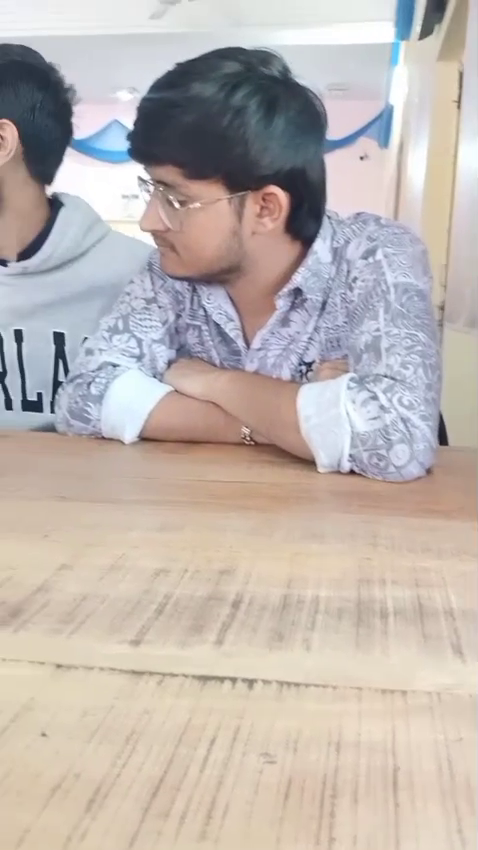

Baseline Frame 40 | FPS: 5.22


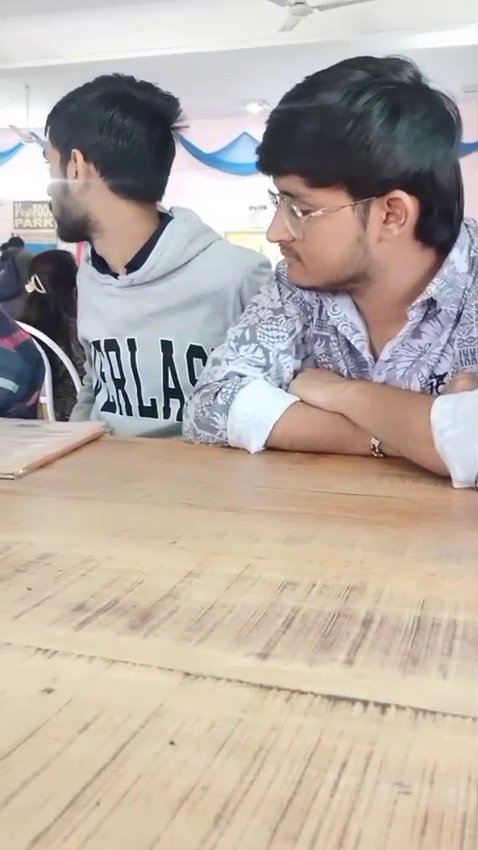

Baseline Frame 60 | FPS: 5.73


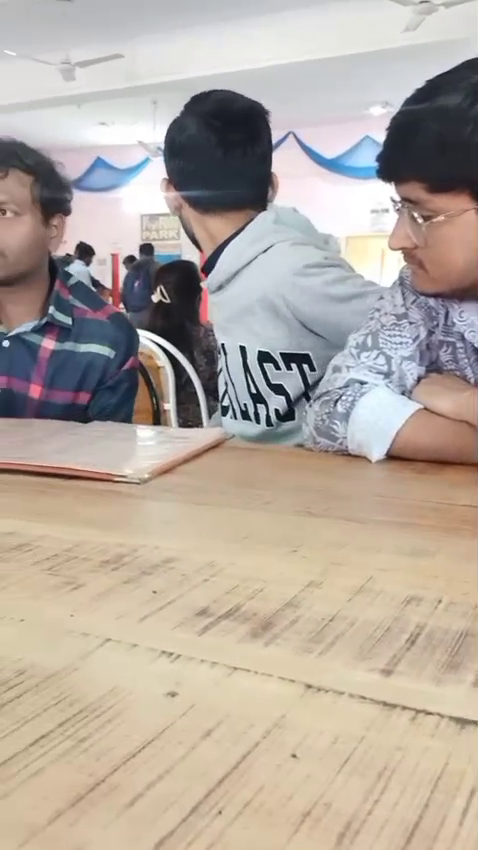

Baseline Frame 80 | FPS: 6.87


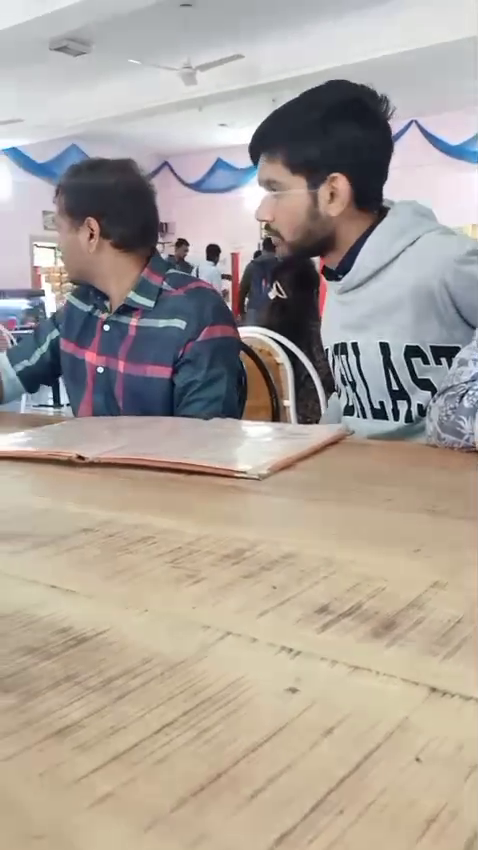

Baseline Frame 100 | FPS: 5.60


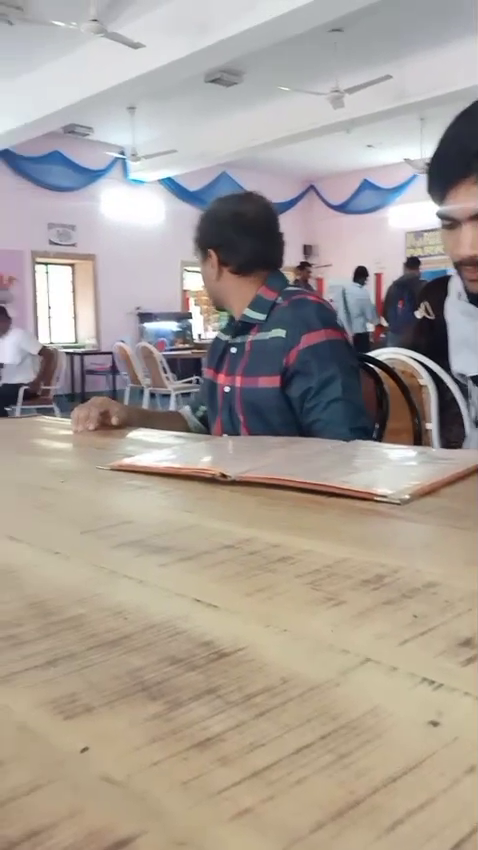

Baseline Frame 120 | FPS: 5.22


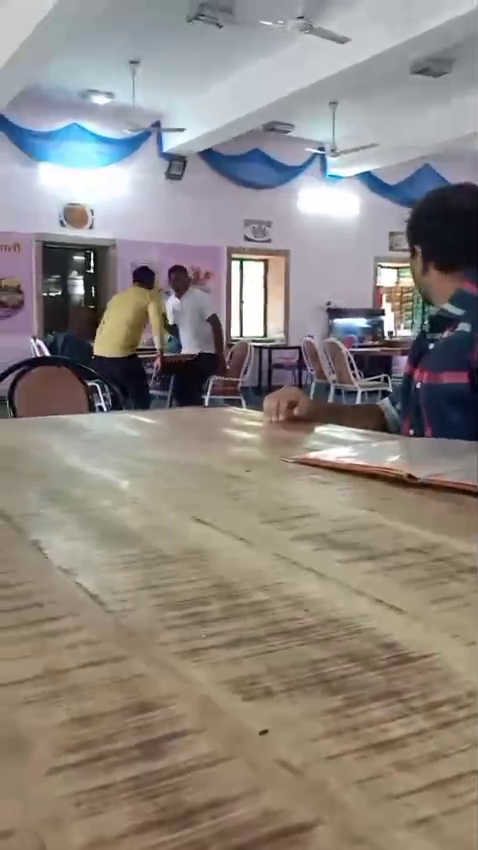

Baseline Frame 140 | FPS: 5.69


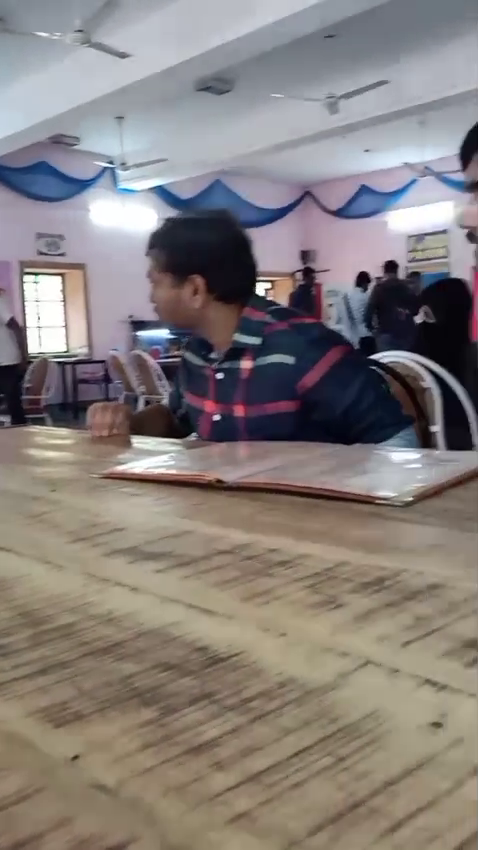

Baseline Frame 160 | FPS: 6.76


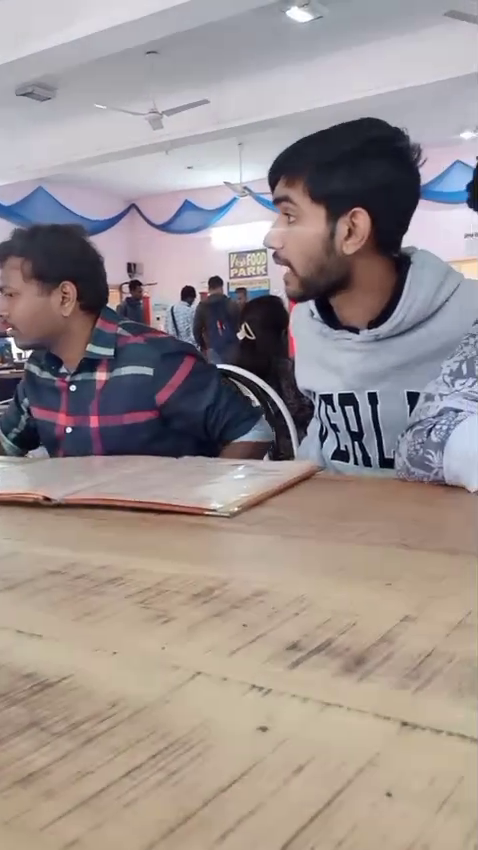

Baseline Frame 180 | FPS: 4.85


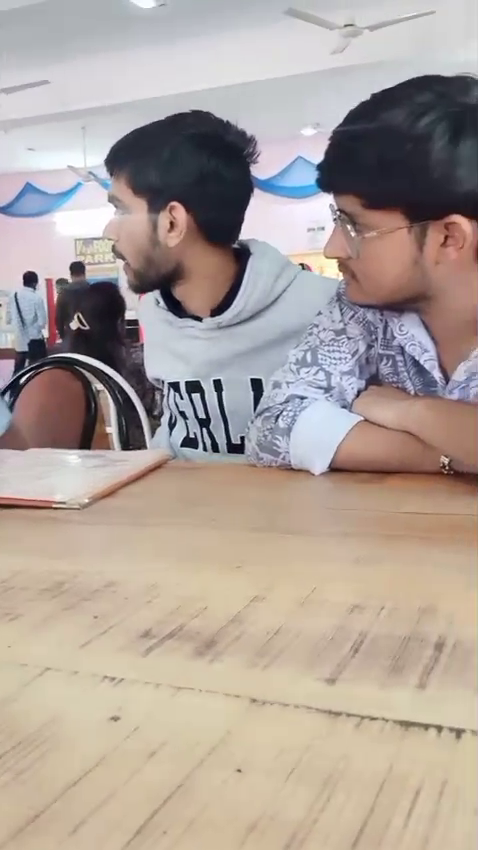

Baseline Frame 200 | FPS: 6.76


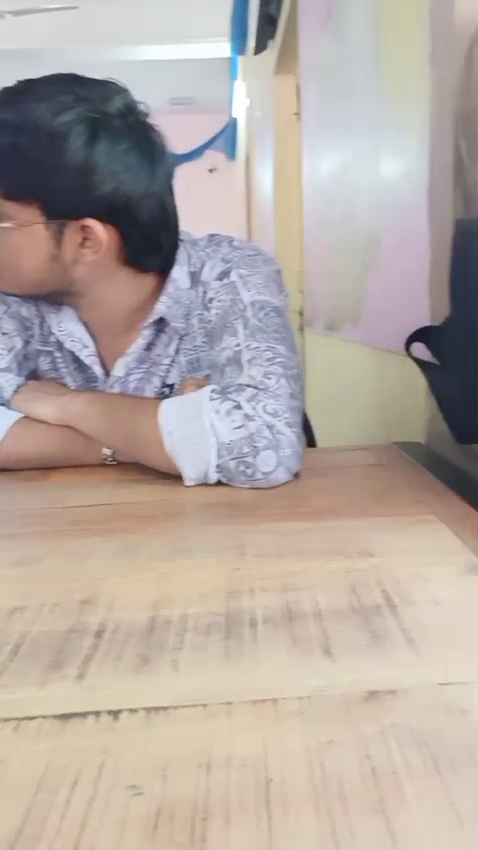

Baseline Frame 220 | FPS: 11.04


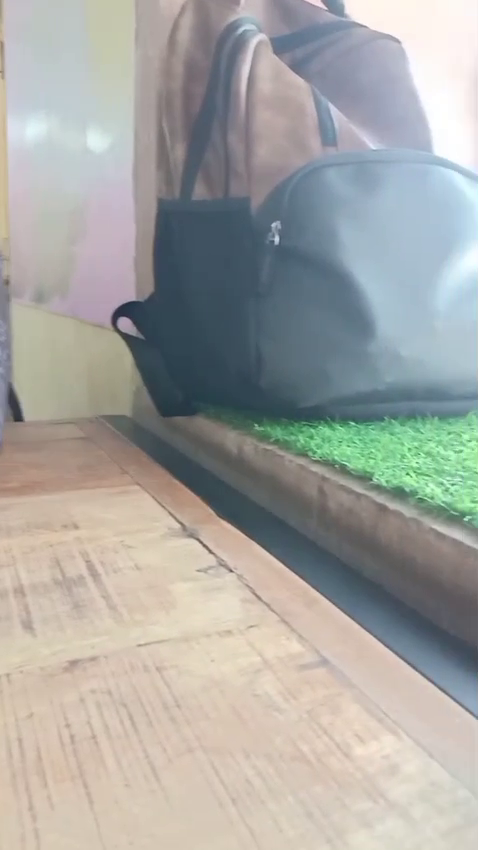

Baseline Frame 240 | FPS: 11.56


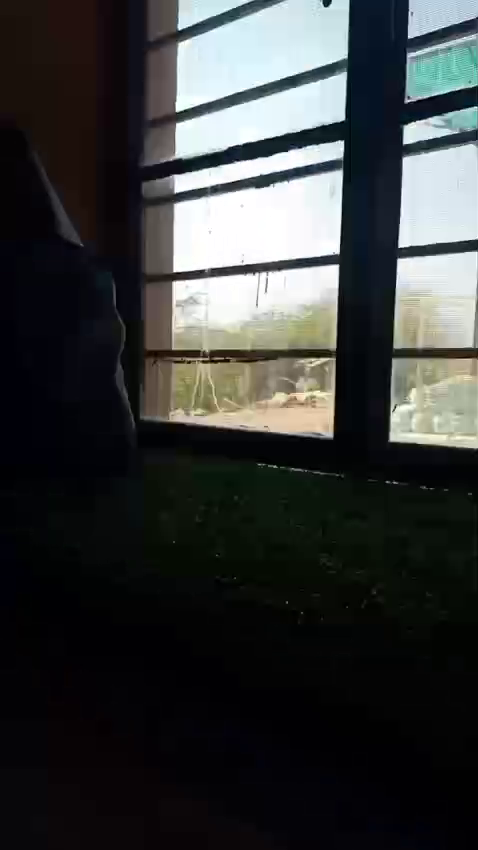

Baseline Frame 260 | FPS: 10.59


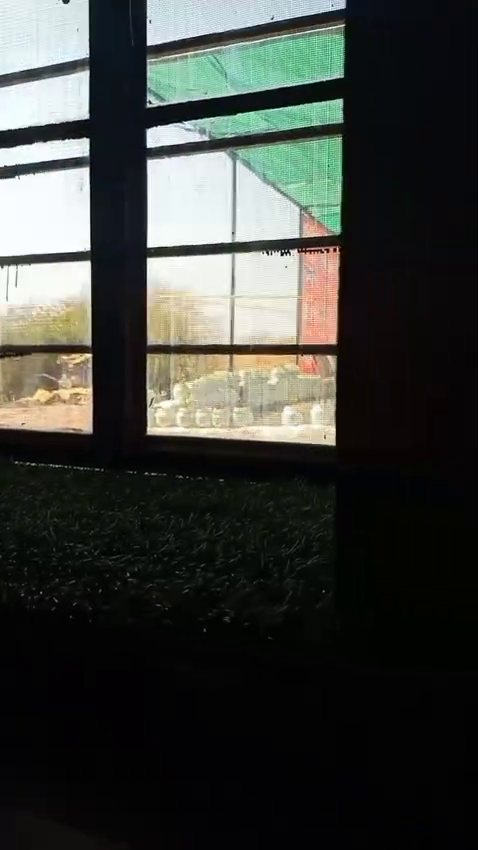

Baseline Frame 280 | FPS: 6.36


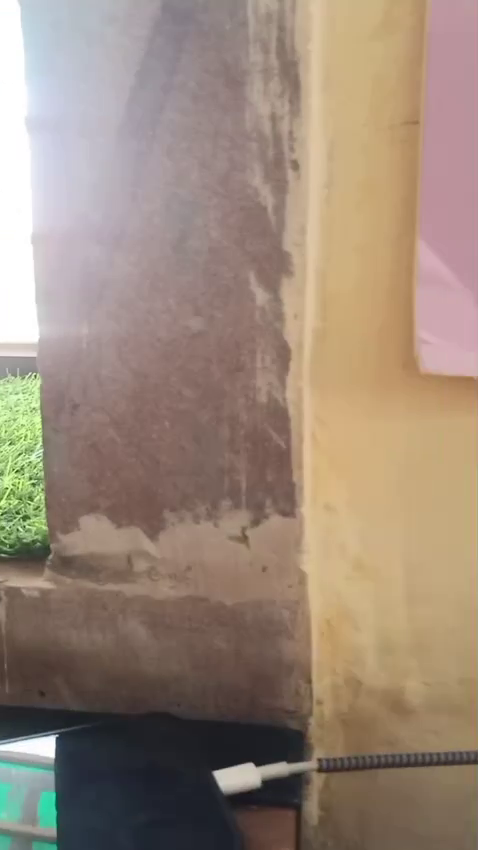

Baseline Frame 300 | FPS: 8.12


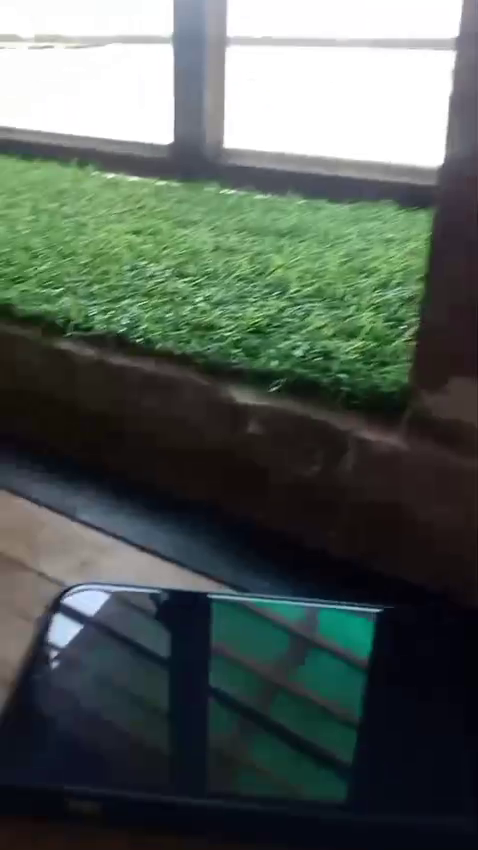

Baseline Frame 320 | FPS: 6.47


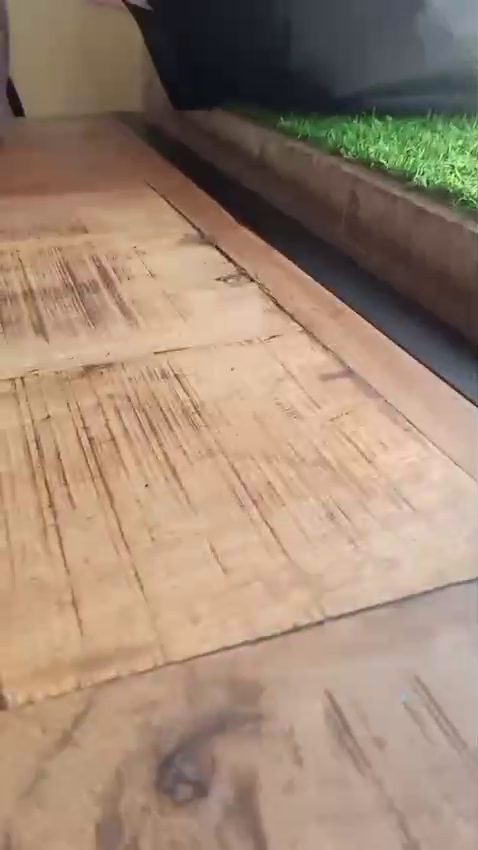


📊 BASELINE PERFORMANCE REPORT
--------------------------------
Total Frames: 320
Average FPS: 6.61
Precision: 1.00
Recall: 0.04
F1 Score: 0.08
TP: 13  FP: 0  FN: 307
✔ Baseline Evaluation Completed


In [ ]:
import cv2
import time
import numpy as np
from google.colab.patches import cv2_imshow

# Load Haar Cascade (Baseline Model)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +
                                    "haarcascade_frontalface_default.xml")

# Video load (use same video_path you set earlier)
cap = cv2.VideoCapture(video_path)

fps_list = []
TP_b = FP_b = FN_b = 0
frame_count_b = 0

print("⏳ Baseline Evaluation Started... (HaarCascade)\n")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    start_time = time.time()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Face detection only (No person detection)
    faces = face_cascade.detectMultiScale(gray, 1.2, 5)

    # Accuracy metric
    if len(faces) > 0:
        TP_b += 1
    else:
        FN_b += 1

    fps = 1 / (time.time() - start_time)
    fps_list.append(fps)

    frame_count_b += 1

    # Show frame every 20 frames
    if frame_count_b % 20 == 0:
        print(f"Baseline Frame {frame_count_b} | FPS: {fps:.2f}")
        cv2_imshow(frame)

cap.release()
cv2.destroyAllWindows()

# Metrics
avg_fps_b = np.mean(fps_list)
precision_b = TP_b / (TP_b + FP_b + 1e-6)
recall_b = TP_b / (TP_b + FN_b + 1e-6)
f1_b = 2*((precision_b*recall_b)/(precision_b+recall_b+1e-6))

print("\n📊 BASELINE PERFORMANCE REPORT")
print("--------------------------------")
print(f"Total Frames: {frame_count_b}")
print(f"Average FPS: {avg_fps_b:.2f}")
print(f"Precision: {precision_b:.2f}")
print(f"Recall: {recall_b:.2f}")
print(f"F1 Score: {f1_b:.2f}")
print(f"TP: {TP_b}  FP: {FP_b}  FN: {FN_b}")
print("✔ Baseline Evaluation Completed")


In [ ]:
import cv2
import torch
import time
import numpy as np
from mtcnn.mtcnn import MTCNN
from google.colab.patches import cv2_imshow

# Load deep learning models
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
yolo_model.eval()
face_detector = MTCNN()

# Video load
cap = cv2.VideoCapture(video_path)
fps_list = []

# Metrics variables
TP = 0  # Correct face/person detected
FP = 0  # Wrong detection
FN = 0  # Missed detection

frame_count = 0
print("🚁 Started Processing ...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    start_time = time.time()

    # YOLOv5 Detection
    results = yolo_model(frame)
    detections = results.xyxy[0].cpu().numpy()

    persons_detected = 0
    faces_detected = []

    # Draw person bounding boxes
    for x1, y1, x2, y2, conf, cls_id in detections:
        label = results.names[int(cls_id)]
        if label == "person" and conf > 0.4:
            persons_detected += 1
            cv2.rectangle(frame,(int(x1),int(y1)),(int(x2),int(y2)),(255,255,0),2)
            cv2.putText(frame,"Person",(int(x1),int(y1)-5),
                        cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,255,0),2)

    # MTCNN Face Detection
    faces = face_detector.detect_faces(frame)
    for f in faces:
        x, y, w, h = f['box']
        faces_detected.append((x,y,w,h))
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
        cv2.putText(frame,"Face",(x,y-10),
                    cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,255,0),2)

    # Accuracy metric logic:
    if persons_detected > 0:
        if len(faces_detected) > 0:
            TP += 1
        else:
            FN += 1
    else:
        if len(faces_detected) > 0:
            FP += 1

    # Latency (FPS)
    curr_time = time.time()
    fps = 1 / (curr_time - start_time)
    fps_list.append(fps)
    cv2.putText(frame, f"FPS: {fps:.2f}", (10, 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 255), 2)

    frame_count += 1
    print(f"📌 Frame {frame_count} | FPS: {fps:.2f}")
    cv2_imshow(frame)

cap.release()
cv2.destroyAllWindows()

# Calculate Metrics
avg_fps = np.mean(fps_list)
precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

print("\n📊 Performance Report")
print("------------------------")
print(f"Total Frames: {frame_count}")
print(f"Average FPS (Latency): {avg_fps:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")
print(f"TP: {TP}  FP: {FP}  FN: {FN}")
print("✔ Evaluation Completed")
